In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, make_scorer, recall_score, precision_score

In [3]:
# read data 
data = pd.read_table('./a3_train_final.tsv', header=None)

data_shuffled = data.sample(frac=1.0, random_state=0)
data_shuffled.columns = ['label', 'comment']

# preprocessing
replacements = {'\'': '', '’': ''}
data_shuffled.replace(replacements, regex=True, inplace=True) 

# get all labels, select most common one (removed if majority is -1)
def most_common(x):
    x = x.split('/')
    if '-1' in x:
        x.remove('-1')
    return max(set(x), key=x.count)

# get all labels, remove all rows that contains -1
def remove_unsure(x):
    x = x.split('/')
    if '-1' in x:
        return '-1'
    return max(set(x), key=x.count)

# get all labels, remove all that has conflicting labels
def remove_all_conflicts(x):
    x = x.split('/')
    if len(set(x)) > 1:
        return '-1'
    return max(set(x), key=x.count)

# get all labels, remove rows that contains -1 and those with equally many 0s and 1s
def remove_ties(x):
    x = x.split('/')
    if '-1' in x:
        return '-1'
    if x.count('1') == x.count('0'):
        return '-1' 
    return max(set(x), key=x.count)

data_most_common_labels = pd.DataFrame.copy(data_shuffled)
data_remove_unsure = pd.DataFrame.copy(data_shuffled)
data_remove_ties = pd.DataFrame.copy(data_shuffled)
data_remove_conflicts = pd.DataFrame.copy(data_shuffled)

data_most_common_labels['label'] = data_shuffled['label'].apply(most_common)
data_remove_unsure['label'] = data_shuffled['label'].apply(remove_unsure)
data_remove_ties['label'] = data_shuffled['label'].apply(remove_ties)
data_remove_conflicts['label'] = data_shuffled['label'].apply(remove_all_conflicts)

# delete rows that should be removed
data_most_common_labels = data_most_common_labels[data_most_common_labels['label'] != '-1']
data_remove_unsure = data_remove_unsure[data_remove_unsure['label'] != '-1']
data_remove_ties = data_remove_ties[data_remove_ties['label'] != '-1']
data_remove_conflicts = data_remove_conflicts[data_remove_conflicts['label'] != '-1']

print(len(data_most_common_labels))
print(len(data_remove_unsure))


37885
34182


In [4]:
test_data = pd.read_table('./a3_test.tsv', header=None)
test_data.columns = ['label', 'comment']
X_test = test_data['comment']
Y_test = test_data['label']

In [5]:
dataframes = [data_most_common_labels, data_remove_unsure, data_remove_ties, data_remove_conflicts]

def split_data(df):
    Y = df['label']
    X = df['comment']
    return X, Y

X_data = []
Y_data = []

for df in dataframes:
    X, Y = split_data(df)
    X_data.append(X)
    Y_data.append(Y)


comments = X_data[3] 

In [6]:
def get_most_common_words(X):
    cv = CountVectorizer()
    X_enc = cv.fit_transform(X)
    
    word_list = cv.get_feature_names_out()
    count_list = X_enc.toarray().sum(axis=0)

    # Convert all strings in count_list to ints
    count_list_int = list(map(int, count_list))

    # Zip the two lists together and create a dictionary
    zipped_lists = zip(word_list, count_list_int)
    counted_words = dict(zipped_lists)

    # Sort the dict from most to least common word
    counted_words_sorted = dict(sorted(counted_words.items(), key=lambda item: item[1], reverse=True))

    # Get n most common words
    n = 3
    dict_items = counted_words_sorted.items()
    most_common_words_occurances = list(dict_items)[:n]
    most_common_words = list(counted_words_sorted.keys())[:n]

    print('Most common words and their occurances:', most_common_words_occurances)
    return most_common_words

def vectorize_tfidf(X, most_common_words):

    tf_vec = TfidfVectorizer(smooth_idf=True, use_idf=True, strip_accents='unicode', stop_words = most_common_words)
    X_enc = tf_vec.fit_transform(X)

    return X_enc, tf_vec

tf_vecs = []

for i, x in enumerate(X_data):
    most_common_words = get_most_common_words(x)
    X_data[i], tf_vec = vectorize_tfidf(x, most_common_words)
    tf_vecs.append(tf_vec)

Most common words and their occurances: [('the', 42663), ('to', 25783), ('and', 23124)]
Most common words and their occurances: [('the', 38579), ('to', 23353), ('and', 21249)]
Most common words and their occurances: [('the', 36084), ('to', 21884), ('and', 19988)]
Most common words and their occurances: [('the', 35886), ('to', 21774), ('and', 19909)]


In [7]:
data_descriptions = {   0: 'select most common label',
                        1: 'remove all rows that contains -1, keep majority label',
                        2: 'remove rows that contains -1 and those with equally many 0s and 1s, keep majority label',
                        3: 'remove rows that has conflicting labels'
}

In [8]:
scoring = {'accuracy': make_scorer(accuracy_score), 
           'f1': make_scorer(f1_score, pos_label='1'), 
            }


**Dummy Classifier**

In [9]:
for i in range(len(X_data)):

    X = X_data[i]
    Y = Y_data[i]

    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(X, Y)
    dummy_results = cross_validate(dummy, X, Y, cv=10, scoring=scoring, error_score="raise")
    
    acc_score = dummy_results['test_accuracy'].mean()
    f1_dummy = dummy_results['test_f1'].mean()

    print(f'Dataset description: {data_descriptions[i]}')
    print(f'Accuracy for Dummy classifier: {round(acc_score, 4)}')
    print(f'F1 score for Dummy classifier: {round(f1_dummy, 4)}\n')

Dataset description: select most common label
Accuracy for Dummy classifier: 0.5265
F1 score for Dummy classifier: 0.0

Dataset description: remove all rows that contains -1, keep majority label
Accuracy for Dummy classifier: 0.5247
F1 score for Dummy classifier: 0.0

Dataset description: remove rows that contains -1 and those with equally many 0s and 1s, keep majority label
Accuracy for Dummy classifier: 0.5036
F1 score for Dummy classifier: 0.6699

Dataset description: remove rows that has conflicting labels
Accuracy for Dummy classifier: 0.5038
F1 score for Dummy classifier: 0.6701



**Random Forest Classifier**


In [27]:
ensemble_size = 30
rf = RandomForestClassifier(ensemble_size)

for i in range(len(X_data)):
    
    X = X_data[i]
    Y = Y_data[i]

    rf.fit(X, Y)

    rf_results = cross_validate(rf, X, Y, cv=10, scoring=scoring, n_jobs=-1)
    acc_score = rf_results['test_accuracy'].mean()
    f1_rf = rf_results['test_f1'].mean()

    print(f'Dataset description: {data_descriptions[i]}')
    print(f'Accuracy for random forest classifier (ensemble size = {ensemble_size}): {round(acc_score, 4)}')
    print(f'F1 score for random forest classifier: {round(f1_rf, 4)}\n')

Dataset description: select most common label
Accuracy for random forest classifier (ensemble size = 30): 0.7681
F1 score for random forest classifier: 0.7421

Dataset description: remove all rows that contains -1, keep majority label
Accuracy for random forest classifier (ensemble size = 30): 0.7761
F1 score for random forest classifier: 0.7521

Dataset description: remove rows that contains -1 and those with equally many 0s and 1s, keep majority label
Accuracy for random forest classifier (ensemble size = 30): 0.7957
F1 score for random forest classifier: 0.7936

Dataset description: remove rows that has conflicting labels
Accuracy for random forest classifier (ensemble size = 30): 0.8002
F1 score for random forest classifier: 0.7974



In [24]:
X = X_data[2]
Y = Y_data[2]

# Grid search for random forest 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 40, 70, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30]
 }

rf = RandomForestClassifier()

rf_cv = GridSearchCV(rf, param_grid, cv=10, n_jobs=-1)
rf_cv.fit(X, Y)

print("tuned hyperparameters: (best parameters) ", rf_cv.best_params_)
print("accuracy:", rf_cv.best_score_)


tuned hyperparameters: (best parameters)  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
accuracy: 0.8106767879198566


**BernoulliNB**

In [12]:
from sklearn.naive_bayes import BernoulliNB

for i in range(len(X_data)):

    X = X_data[i]
    Y = Y_data[i]

    bnb = BernoulliNB()

    bnb.fit(X, Y)

    bnb_results = cross_validate(bnb, X, Y, cv=10, scoring=scoring)
    acc_score = bnb_results['test_accuracy'].mean()
    f1_bnb = bnb_results['test_f1'].mean()

    print(f'Dataset description: {data_descriptions[i]}')
    print(f'Accuracy for BernoulliNB classifier: {round(acc_score, 4)}')
    print(f'F1 score for BernoulliNB classifier: {round(f1_bnb, 4)}\n')

Dataset description: select most common label
Accuracy for BernoulliNB classifier: 0.7796
F1 score for BernoulliNB classifier: 0.7572

Dataset description: remove all rows that contains -1, keep majority label
Accuracy for BernoulliNB classifier: 0.7893
F1 score for BernoulliNB classifier: 0.7698

Dataset description: remove rows that contains -1 and those with equally many 0s and 1s, keep majority label
Accuracy for BernoulliNB classifier: 0.8086
F1 score for BernoulliNB classifier: 0.8029

Dataset description: remove rows that has conflicting labels
Accuracy for BernoulliNB classifier: 0.8091
F1 score for BernoulliNB classifier: 0.8035



**MultinomialNB**

In [13]:
from sklearn.naive_bayes import MultinomialNB

for i in range(len(X_data)):

    X = X_data[i]
    Y = Y_data[i]    

    mnb = MultinomialNB()
    mnb.fit(X, Y)

    mnb_results = cross_validate(bnb, X, Y, cv=10, scoring=scoring)
    acc_mnb = mnb_results['test_accuracy'].mean()
    f1_mnb= mnb_results['test_f1'].mean()

    print(f'Dataset description: {data_descriptions[i]}')
    print(f'Accuracy for MultinomialNB classifier: {round(acc_mnb, 4)}')
    print(f'F1 score for MultinomialNB classifier: {round(f1_mnb, 4)}\n')

Dataset description: select most common label
Accuracy for MultinomialNB classifier: 0.7796
F1 score for MultinomialNB classifier: 0.7572

Dataset description: remove all rows that contains -1, keep majority label
Accuracy for MultinomialNB classifier: 0.7893
F1 score for MultinomialNB classifier: 0.7698

Dataset description: remove rows that contains -1 and those with equally many 0s and 1s, keep majority label
Accuracy for MultinomialNB classifier: 0.8086
F1 score for MultinomialNB classifier: 0.8029

Dataset description: remove rows that has conflicting labels
Accuracy for MultinomialNB classifier: 0.8091
F1 score for MultinomialNB classifier: 0.8035



In [14]:
X = X_data[2]
Y = Y_data[2]

# Grid search for Multinomial NB
param_grid = {  
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior': (True, False),
    'force_alpha': (True, False)
}  

mnb = MultinomialNB()

mnb_cv = GridSearchCV(mnb, param_grid, cv=10, n_jobs=-1)
mnb_cv.fit(X, Y)

print("tuned hyperparameters: (best parameters) ", mnb_cv.best_params_)
print("accuracy:", mnb_cv.best_score_)

tuned hyperparameters: (best parameters)  {'alpha': 1, 'fit_prior': False, 'force_alpha': True}
accuracy: 0.8186438001316819


**SVC**

In [28]:
# Grid search for linear svc
X = X_data[2]
Y = Y_data[2]

param_grid = {'C':[1,3,5],'tol':[1,0.1,0.001,0.0001]}

svc = LinearSVC()

svc_cv = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1)
svc_cv.fit(X, Y)

print("tuned hyperparameters: (best parameters) ", svc_cv.best_params_)
print("accuracy:", svc_cv.best_score_)

tuned hyperparameters: (best parameters)  {'C': 1, 'tol': 1}
accuracy: 0.8299595438227195


In [16]:
for i in range(len(X_data)):

    X = X_data[i]
    Y = Y_data[i]

    svc = LinearSVC(loss='hinge', max_iter=10000, tol=0.1)

    svc.fit(X, Y)
    svc_results = cross_validate(svc, X, Y, cv=10, scoring=scoring)
    acc_svc = svc_results['test_accuracy'].mean()
    f1_svc= svc_results['test_f1'].mean()
    print(f'Dataset description: {data_descriptions[i]}')
    print(f'Accuracy for SVC classifier (parameters set): {round(acc_svc, 4)}')
    print(f'F1 score for SVC classifier (parameters set): {round(f1_svc, 4)}\n')

Dataset description: select most common label
Accuracy for SVC classifier (parameters set): 0.8002
F1 score for SVC classifier (parameters set): 0.7875

Dataset description: remove all rows that contains -1, keep majority label
Accuracy for SVC classifier (parameters set): 0.8119
F1 score for SVC classifier (parameters set): 0.8012

Dataset description: remove rows that contains -1 and those with equally many 0s and 1s, keep majority label
Accuracy for SVC classifier (parameters set): 0.832
F1 score for SVC classifier (parameters set): 0.833

Dataset description: remove rows that has conflicting labels
Accuracy for SVC classifier (parameters set): 0.8323
F1 score for SVC classifier (parameters set): 0.8333



**SVM**

In [17]:
for i in range(len(X_data)):
    X = X_data[i]
    Y = Y_data[i]
    svm = SGDClassifier(loss='hinge', max_iter=10, tol=0.1, eta0=0.03)

    svm.fit(X, Y)
    svm_results = cross_validate(svm, X, Y, cv=10, scoring=scoring)
    acc_svm = svm_results['test_accuracy'].mean()
    f1_svm = svm_results['test_f1'].mean()
    print(f'Dataset description: {data_descriptions[i]}')
    print(f'Accuracy for SVM classifier (parameters set): {round(acc_svm, 4)}')
    print(f'F1 score for SVM classifier (parameters set): {round(f1_svm, 4)}\n')

Dataset description: select most common label
Accuracy for SVM classifier (parameters set): 0.7969
F1 score for SVM classifier (parameters set): 0.7803

Dataset description: remove all rows that contains -1, keep majority label
Accuracy for SVM classifier (parameters set): 0.8078
F1 score for SVM classifier (parameters set): 0.7941

Dataset description: remove rows that contains -1 and those with equally many 0s and 1s, keep majority label
Accuracy for SVM classifier (parameters set): 0.827
F1 score for SVM classifier (parameters set): 0.8266

Dataset description: remove rows that has conflicting labels
Accuracy for SVM classifier (parameters set): 0.827
F1 score for SVM classifier (parameters set): 0.8263



In [29]:
param_grid = {'eta0': [0.03, 0.01, 0.003, 0.001, 0.0003],
              'penalty': ['l1', 'l2', 'elasticnet'],
              'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
              'loss': ['hinge'],
              'tol':[1,0.1,0.001,0.0001]
              }

X = X_data[2]
Y = Y_data[2]


svm = SGDClassifier()

svm_cv = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1)
svm_cv.fit(X, Y)

print("tuned hyperparameters: (best parameters) ", svm_cv.best_params_)
print("accuracy:", svm_cv.best_score_)

tuned hyperparameters: (best parameters)  {'alpha': 0.0001, 'eta0': 0.003, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.1}
accuracy: 0.8274793369762156


**Logistic Regression**

In [19]:
def logr_feature_importance(logreg, vec):
    importance = logreg.coef_[0]

    feat_names = vec.get_feature_names_out()

    zipped = list(zip(feat_names, importance))

    sorted_zip = sorted(zipped, key = lambda x: x[1], reverse=False)

    n = 10

    n_most_negative = sorted(importance)[0:n]
    n_most_positive = sorted(importance)[-n:]

    most_important = n_most_negative + n_most_positive

    names = []
    for i in range(1, n+1):
        names.append(sorted_zip[i-1][0])

    for i in range (1, n+1):
        names.append(sorted_zip[-i][0])

    plt.bar([x for x in range(len(most_important))], most_important)
    plt.xticks(range(len(names)), names, fontsize=12, rotation='vertical')

    plt.show()

Dataset description: select most common label
Accuracy for logistic regression (parameters set): 0.8003
F1 score for logistic regression (parameters set): 0.7869



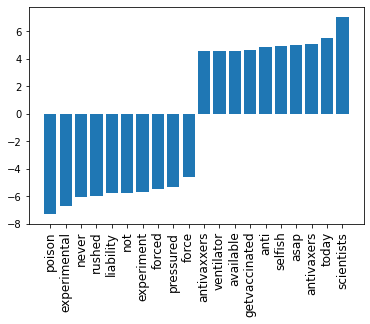

Dataset description: remove all rows that contains -1, keep majority label
Accuracy for logistic regression (parameters set): 0.8099
F1 score for logistic regression (parameters set): 0.7984



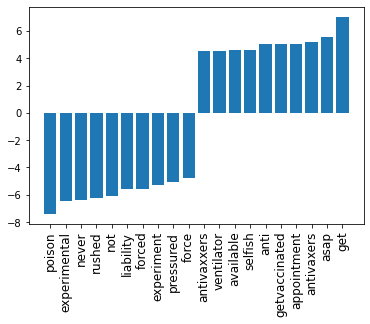

Dataset description: remove rows that contains -1 and those with equally many 0s and 1s, keep majority label
Accuracy for logistic regression (parameters set): 0.8333
F1 score for logistic regression (parameters set): 0.834



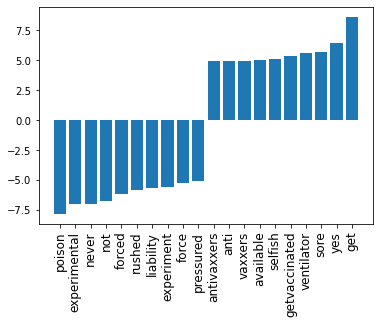

Dataset description: remove rows that has conflicting labels
Accuracy for logistic regression (parameters set): 0.8336
F1 score for logistic regression (parameters set): 0.8342



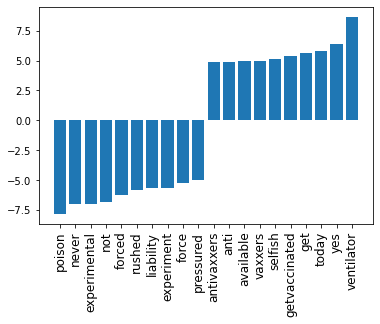

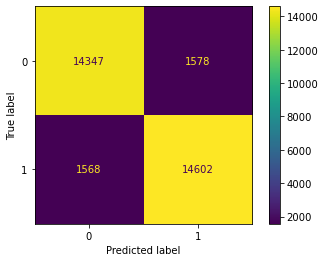

In [30]:
# l2 gives highest accuracy 
logreg = LogisticRegression(max_iter=10000, C=4, tol=0.1)

for i in range(len(X_data)):
    X = X_data[i]
    Y = Y_data[i]
    vec = tf_vecs[i]

    logreg.fit(X, Y)
    lgr_results = cross_validate(logreg, X, Y, cv=10, scoring=scoring)
    acc_lgr = lgr_results['test_accuracy'].mean()
    f1_lgr= lgr_results['test_f1'].mean()
    print(f'Dataset description: {data_descriptions[i]}')
    print(f'Accuracy for logistic regression (parameters set): {round(acc_lgr, 4)}')
    print(f'F1 score for logistic regression (parameters set): {round(f1_lgr, 4)}\n')
    logr_feature_importance(logreg, vec)

predictions = logreg.predict(X)
cm = confusion_matrix(Y, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()

plt.show()


In [21]:
# Looking at some examples of misclassified comments
for i in range(100):
    if Y.iloc[i] != predictions[i]:
        print(f"Actual label: {Y.iloc[i]}, Classified Label: {predictions[i]}")
        print(comments.iloc[i])
        print('\n')

Actual label: 0, Classified Label: 1
Yea I know 3 people who have had both vaccines... And both have caught covid after!


Actual label: 0, Classified Label: 1
Simply because even though vaccinated a person can still carry and spread the virus. This was explained during rollout and it was also explained that infection after vaccination was expected. Thats why we asked "So what is the point of getting the vaccine in the first place?"


Actual label: 1, Classified Label: 0
No its like the mechanic saying there is nothing wrong with your car, while its definitely making a noise youve never heard it make before.


Actual label: 1, Classified Label: 0
If you are still worried about microchips in vaccines, just know that your life isnt interesting enough to track.


Actual label: 1, Classified Label: 0
 Vaccine takes more than a year to develop.  This is the mistake people are making. Its not 1976 anymore. Vaccines do not take years to make.


Actual label: 0, Classified Label: 1
Once again 

In [22]:
# Grid search for logistic regression
from warnings import simplefilter 
import warnings
simplefilter(action="ignore")
warnings.filterwarnings("ignore")

X = X_data[3]
Y = Y_data[3]

c = [0, 1, 3, 4, 5, 6, 7, 10, 15, 20]

param_grid = {
            #"C": np.logspace(-3, 3, 7),
            "C": c, 
            "penalty": ["l1","l2"],
            "tol": [0.0001, 0.00001, 0.001, 0.1, 1]
        }

logreg = LogisticRegression(max_iter=1000)

logreg_cv = GridSearchCV(logreg, param_grid, cv=10, n_jobs=-1)
logreg_cv.fit(X, Y)

print("tuned hyperparameters: (best parameters) ", logreg_cv.best_params_)
print("accuracy:", logreg_cv.best_score_)

tuned hyperparameters: (best parameters)  {'C': 4, 'penalty': 'l2', 'tol': 0.1}
accuracy: 0.8334948630652302


In [31]:
final_vec = tf_vecs[3]
X_test_enc = final_vec.transform(X_test)

test_predictions = logreg.predict(X_test_enc)
Y_test = Y_test.astype(str) 
final_score = accuracy_score(Y_test, test_predictions)
f1 = f1_score(Y_test, test_predictions, pos_label='1')

print(f"Accuracy on the test set: {round(final_score, 4)}")
print(f"F1 score on the test set: {round(f1, 4)}")


Accuracy on the test set: 0.8589
F1 score on the test set: 0.8588


In [ ]:
# Looking at some examples of misclassified comments in the test set
for i in range(50,100):
    if Y_test.iloc[i] != test_predictions[i]:
        print(f"Actual label: {Y_test.iloc[i]}, Classified Label: {test_predictions[i]}")
        print(X_test.iloc[i])
        print('\n')

Actual label: 0, Classified Label: 1
After my second Pfizer shot I had. 105.2 fever and convulsions… then pneumonia for 2 weeks… the doctors wanted me to keep my mouth shut and not blame the shot I received


Actual label: 1, Classified Label: 0
All I can say is wow!!


Actual label: 0, Classified Label: 1
Alright I don’t think watching this video is gonna make me less scared to get the vaccine


Actual label: 0, Classified Label: 1
Alright, so now look into the covid protein spike and it's prion capable modification. Make sure you understand what you are getting yourself into when you take those shots, and it will also shed some light on the side effects you may have seen.


Actual label: 0, Classified Label: 1
Am vaccine free and glad i didnt comply. Feel bad for those who did.


Actual label: 1, Classified Label: 0
And a vaccine literally introduces the virus to your immune system in a non harmful way... Good food doesn't produce antibodies, a vaccine does.


Actual label: 1, Classi

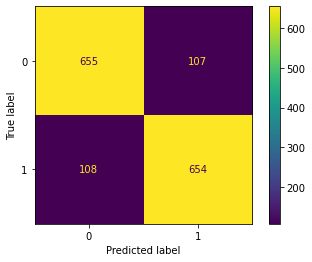

In [ ]:
# Confusion matrix for the test set
cm = confusion_matrix(Y_test, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()

plt.show()